# Сверточные нейронные сети
Для использования нейронных сетей этой тетради необходимо взять файлы из каталогов, использованных на предыдущей лекции.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision

In [12]:
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## CNNNet (или AlexNet)

In [13]:
class CNNNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [14]:
cnnnet = CNNNet()

In [15]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [16]:
from google.colab import drive
drive.mount('/content/drive')
# X_train, y_train = load_mnist('/content/drive/My Drive/Colab Notebooks/mnist/', kind='train')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_data_path = "/content/drive/My Drive/Colab Notebooks/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)

val_data_path = "/content/drive/My Drive/Colab Notebooks/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)

batch_size = 32

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [18]:
cnnnet.to(device)
optimizer = optim.Adam(cnnnet.parameters(), lr=0.00001)

In [20]:
train(cnnnet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=20, device=device)

<ipython-input-15-f38d79bc5988>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 0, Training Loss: 0.44, Validation Loss: 0.41, accuracy = 0.81
Epoch: 1, Training Loss: 0.44, Validation Loss: 0.40, accuracy = 0.79
Epoch: 2, Training Loss: 0.43, Validation Loss: 0.41, accuracy = 0.81
Epoch: 3, Training Loss: 0.43, Validation Loss: 0.43, accuracy = 0.80
Epoch: 4, Training Loss: 0.42, Validation Loss: 0.40, accuracy = 0.81
Epoch: 5, Training Loss: 0.42, Validation Loss: 0.38, accuracy = 0.84
Epoch: 6, Training Loss: 0.42, Validation Loss: 0.35, accuracy = 0.85
Epoch: 7, Training Loss: 0.42, Validation Loss: 0.37, accuracy = 0.85
Epoch: 8, Training Loss: 0.43, Validation Loss: 0.37, accuracy = 0.85
Epoch: 9, Training Loss: 0.41, Validation Loss: 0.45, accuracy = 0.79
Epoch: 10, Training Loss: 0.40, Validation Loss: 0.39, accuracy = 0.82
Epoch: 11, Training Loss: 0.40, Validation Loss: 0.38, accuracy = 0.84
Epoch: 12, Training Loss: 0.40, Validation Loss: 0.48, accuracy = 0.78
Epoch: 13, Training Loss: 0.40, Validation Loss: 0.36, accuracy = 0.86
Epoch: 14, Train

## Задание 1
Передайте в модель одно из изображений в проверочной выборке и получите предсказание классификатора.

In [22]:
def pre_image(image_path, model):
    img = Image.open(image_path)
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    transform_norm = transforms.Compose([
                        transforms.ToTensor(), 
                        transforms.Resize((64,64)),
                        transforms.Normalize(mean, std)])
    img_normalized = transform_norm(img).float()
    img_normalized = img_normalized.unsqueeze_(0)
    img_normalized = img_normalized.to(device)
    with torch.no_grad():
        model.eval()  
        output = model(img_normalized)
        index = output.data.cpu().numpy().argmax()
        classes = train_data.classes
        class_name = classes[index]
        return class_name

In [23]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


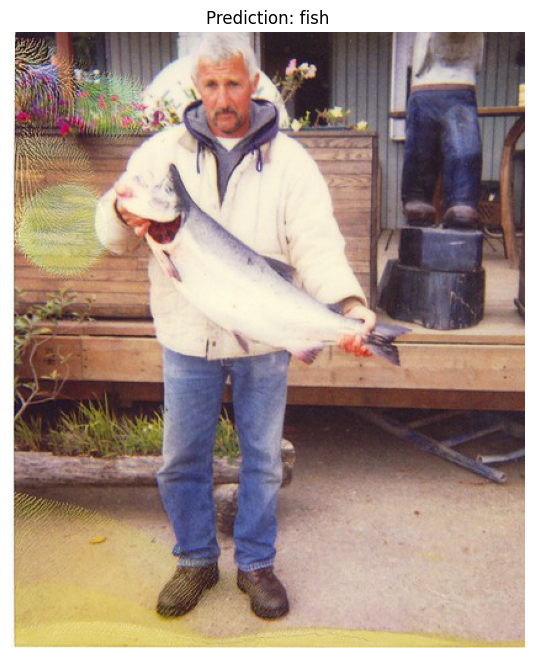

In [26]:
import os
import random

while True:
    dirname = random.choice(["/content/drive/My Drive/Colab Notebooks/test/cat/", '/content/drive/My Drive/Colab Notebooks/test/fish/'])
    filename = random.choice(os.listdir(dirname))
    path = os.path.join(dirname, filename)
    if check_image(path):
        break
    else:
        continue

predict_class = pre_image(path, cnnnet)
plt.figure(figsize=(10,8))
plt.imshow(np.asarray(Image.open(path)), cmap='gray_r')
plt.title(f"Prediction: {predict_class}")
plt.axis('off')
plt.show()

## Задание 2
Настройте модель CNNNet на предсказание данных MNIST, выполните обучение модели и получите предсказание на случайно выбранном данном. 

In [28]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random

batch_size = 64
num_epochs = 10

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [29]:
class CNNNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [30]:
model = CNNNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss /= len(test_loader)
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, val_loss, val_accuracy))

    model.train()

Epoch [1/10], Step [100/938], Loss: 0.2260
Epoch [1/10], Step [200/938], Loss: 0.2894
Epoch [1/10], Step [300/938], Loss: 0.1188
Epoch [1/10], Step [400/938], Loss: 0.1414
Epoch [1/10], Step [500/938], Loss: 0.1674
Epoch [1/10], Step [600/938], Loss: 0.2101
Epoch [1/10], Step [700/938], Loss: 0.2131
Epoch [1/10], Step [800/938], Loss: 0.0955
Epoch [1/10], Step [900/938], Loss: 0.0367
Epoch [1/10], Validation Loss: 0.0479, Validation Accuracy: 98.39%
Epoch [2/10], Step [100/938], Loss: 0.2359
Epoch [2/10], Step [200/938], Loss: 0.1105
Epoch [2/10], Step [300/938], Loss: 0.1270
Epoch [2/10], Step [400/938], Loss: 0.1311
Epoch [2/10], Step [500/938], Loss: 0.0580
Epoch [2/10], Step [600/938], Loss: 0.0345
Epoch [2/10], Step [700/938], Loss: 0.0650
Epoch [2/10], Step [800/938], Loss: 0.0692
Epoch [2/10], Step [900/938], Loss: 0.1075
Epoch [2/10], Validation Loss: 0.0395, Validation Accuracy: 98.59%
Epoch [3/10], Step [100/938], Loss: 0.0251
Epoch [3/10], Step [200/938], Loss: 0.2226
Epoch 

In [32]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 99.36 %


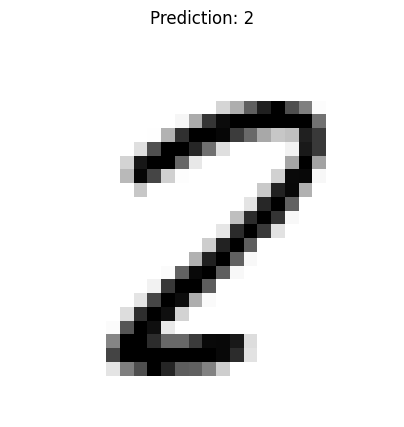

In [33]:
image, label = test_dataset[random.randint(0, len(test_dataset))]
model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)

plt.figure(figsize=(5,5))
plt.imshow(image.squeeze(), cmap='gray_r')
plt.title(f"Prediction: {predicted.item()}")
plt.axis('off')
plt.show()

## Загрузка предобученных моделей 

Существует два способа загрузки предварительно подготовленных моделей изображений с помощью PyTorch. Во-первых, вы можете использовать библиотеку `torch vision.models`.

In [34]:
import torchvision.models as models
alexnet = models.alexnet(num_classes=1000, pretrained=True)
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 80.9MB/s]
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [35]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 